# Get Kicker data from aws mySQL DB

In [1]:
import mysql.connector
import pandas as pd
import numpy as np
from pandas import DataFrame
from mysql.connector import errorcode
import matplotlib.pyplot as plt
% matplotlib inline

config = {
'user': 'db_gtown_2018',
'password': 'Gtown2018',
'port': '3306',
'host': 'nflnumbers.czuayagz62va.us-east-1.rds.amazonaws.com',
'database': 'db_nfl',
'raise_on_warnings': True,
}
 
try:
    cnx = mysql.connector.connect(**config)
    cursor = cnx.cursor()
    #Let's read all the rows in the table
    readContactPerson = """SELECT FGXP, PBP.GID, PBP.FKICKER, 
    TIMO AS TIMO_REMAIN,
    CASE WHEN GOOD = 'Y' THEN 1 ELSE 0 END AS SUCCESS,
    CASE WHEN UPPER(DETAIL) LIKE '%BLOCKED%' THEN 1 ELSE 0 END AS BLOCKED,
    DPOS AS DRAFT_POSITION,
    DIST - (100 - CASE WHEN YFOG = '' THEN '98' ELSE YFOG END) AS YDS_BEHIND_LOS,
    PTSO - PTSD AS POINT_DIFFERENTIAL,
    CASE WHEN QTR IN ('2' , '4') AND MIN <= 2 AND (PTSO - PTSD) >= - 3 THEN 1 ELSE 0 END AS HIGH_PRESSURE,
    TEMP, HUMD, WSPD, COND, SURF,
    PLAYER.height,PLAYER.weight,
    FLOOR((TO_DAYS(NOW()) - TO_DAYS(STR_TO_DATE( dob , "%m/%d/%Y" )))/365) AS AGE, 
    (YEAR(CURDATE()) - PLAYER.start) AS YEARS_PLAYED,
    PLAYER.forty,PLAYER.bench,PLAYER.vertical,PLAYER.broad,PLAYER.shuttle,PLAYER.cone,
    PLAYER.arm,PLAYER.hand,PLAYER.dcp
    FROM PBP
    LEFT OUTER JOIN PLAYER PLAYER ON PBP.FKICKER = PLAYER.PLAYER
    LEFT OUTER JOIN GAME ON PBP.GID = GAME.GID
    WHERE TYPE = 'FGXP' AND POS1 = 'K'
    ORDER BY PBP.FKICKER , PBP.GID;"""
    cursor.execute(readContactPerson)
    #specify the attributes that you want to display
    df = DataFrame(cursor.fetchall())    
    
    cnx.commit()
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    cursor.close()
    cnx.close()

In [2]:
df.columns = ['FGXP','GID','FKICKER','TIMO_REMAIN','SUCCESS','BLOCKED','DRAFT_POSITION','YDS_BEHIND_LOS','POINT_DIFFERENTIAL','HIGH_PRESSURE','TEMP','HUMD','WSPD','COND','SURF',
             'height','weight','AGE','YEARS_PLAYED',
             'forty','bench','vertical','broad','shuttle','cone',
             'arm','hand','dcp']

In [3]:
df.head(3)

,FGXP,GID,FKICKER,TIMO_REMAIN,SUCCESS,BLOCKED,DRAFT_POSITION,YDS_BEHIND_LOS,POINT_DIFFERENTIAL,HIGH_PRESSURE,...,YEARS_PLAYED,forty,bench,vertical,broad,shuttle,cone,arm,hand,dcp
0,FG,14,AD-0800,3,1,0,0,18.0,-7,0,...,34,0.0,0,0.0,0,0.0,0.0,0,0.0,0
1,FG,14,AD-0800,0,1,0,0,18.0,-4,0,...,34,0.0,0,0.0,0,0.0,0.0,0,0.0,0
2,XP,14,AD-0800,3,1,0,0,18.0,0,0,...,34,0.0,0,0.0,0,0.0,0.0,0,0.0,0


## Number of XPs vs FGs 

In [4]:
df['FGXP'].value_counts()

XP    22000
FG    18164
Name: FGXP, dtype: int64

Number of XPs are slightly more than FGs 

## Success/Fail count by FG or XP

In [5]:
df.groupby(['FGXP','SUCCESS'])['FGXP'].count()

FGXP  SUCCESS
FG    0           3241
      1          14923
XP    0            435
      1          21565
Name: FGXP, dtype: int64

Success to fail ratio of XPs is more than Success to fail of FGs

## Weather conditions

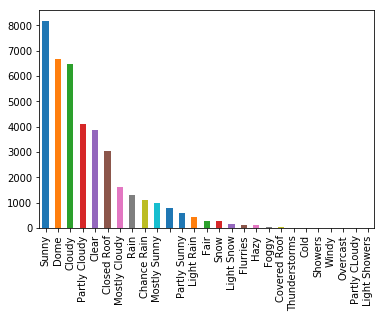

In [6]:
% matplotlib inline
df["COND"].value_counts().plot(kind='bar')

too many weather categories, lets group them

In [7]:
WeatherConditionsDifficultyLevel = {
    'unknown': '',
    'normal':['Closed Roof','Covered Roof','Dome','Clear','Cloudy',
              'Partly Cloudy','Mostly Cloudy','Fair','Partly CLoudy',
              'Sunny','Mostly Sunny','Partly Sunny'],
    'hard':['Chance Rain','Light Rain','Flurries','Light Snow','Light Showers'],
    'extreme':['Rain','Showers','Snow','Foggy','Hazy','Thunderstorms','Cold',
               'Windy','Overcast']
}

In [8]:
def multiple_replace(dict, text):
    for k,v in dict.items():        
        for val in dict[k]:
            if(val == text):
                return k
    return text
dfc = df.apply(lambda row: multiple_replace(WeatherConditionsDifficultyLevel, row['COND']), axis=1)

In [9]:
df["WeatherCondition"] = dfc
df.head(2)

,FGXP,GID,FKICKER,TIMO_REMAIN,SUCCESS,BLOCKED,DRAFT_POSITION,YDS_BEHIND_LOS,POINT_DIFFERENTIAL,HIGH_PRESSURE,...,forty,bench,vertical,broad,shuttle,cone,arm,hand,dcp,WeatherCondition
0,FG,14,AD-0800,3,1,0,0,18.0,-7,0,...,0.0,0,0.0,0,0.0,0.0,0,0.0,0,normal
1,FG,14,AD-0800,0,1,0,0,18.0,-4,0,...,0.0,0,0.0,0,0.0,0.0,0,0.0,0,normal


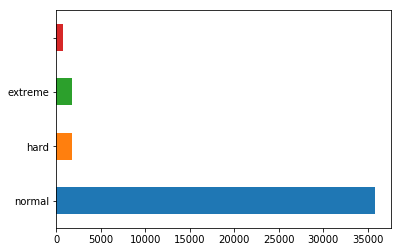

In [10]:
df["WeatherCondition"].value_counts().plot(kind='barh')

## SURF

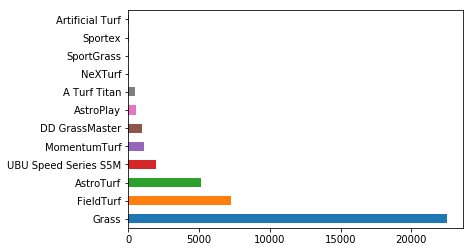

In [11]:
df["SURF"].value_counts().plot(kind='barh')

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
TIMO_REMAIN,40164.0,2.381486,0.887503,0.0,2.0,3.0,3.0,3.000
SUCCESS,40164.0,0.908475,0.288357,0.0,1.0,1.0,1.0,1.000
BLOCKED,40164.0,0.013843,0.116842,0.0,0.0,0.0,0.0,1.000
DRAFT_POSITION,40164.0,57.472363,84.816127,0.0,0.0,0.0,118.0,329.000
YDS_BEHIND_LOS,40164.0,19.190992,3.765821,10.0,18.0,18.0,18.0,31.000
POINT_DIFFERENTIAL,40164.0,3.887113,10.566627,-49.0,-3.0,4.0,10.0,59.000
HIGH_PRESSURE,40164.0,0.154019,0.360971,0.0,0.0,0.0,0.0,1.000
height,40164.0,71.946370,1.939506,67.0,71.0,72.0,73.0,77.000
weight,40164.0,201.608132,16.202634,164.0,190.0,200.0,210.0,250.000
AGE,40164.0,39.042053,8.421407,22.0,33.0,40.0,43.0,84.000


In [13]:
df["AGE"].describe()

count    40164.000000
mean        39.042053
std          8.421407
min         22.000000
25%         33.000000
50%         40.000000
75%         43.000000
max         84.000000
Name: AGE, dtype: float64

In [14]:
df["YEARS_PLAYED"].describe()

count    40164.000000
mean        16.056742
std          7.164953
min          1.000000
25%         11.000000
50%         16.000000
75%         20.000000
max         36.000000
Name: YEARS_PLAYED, dtype: float64

In [15]:
corr_matrix = df.corr().abs()
high_corr_var=np.where(corr_matrix>0.8)
high_corr_var=[(corr_matrix.index[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
high_corr_var

[('AGE', 'YEARS_PLAYED'), ('shuttle', 'cone'), ('arm', 'hand')]